In [1]:
from src.stats import standard, min_max_normalize, pca

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from statsmodels.graphics.tsaplots import plot_acf
plt.style.use('fivethirtyeight')

In [2]:
features = pd.read_csv('data/ec_forecast_ufv_bom_jesus.csv', sep=';', index_col=0)
target = pd.read_csv('data/ufv_bom_jesus_da_lapa_gen.csv', sep=',',index_col=0)
target.index = pd.to_datetime(target.index)
features.index = pd.to_datetime(features.index)

df = features.merge(target, right_index=True, left_index=True)
df_scaled = min_max_normalize(df)

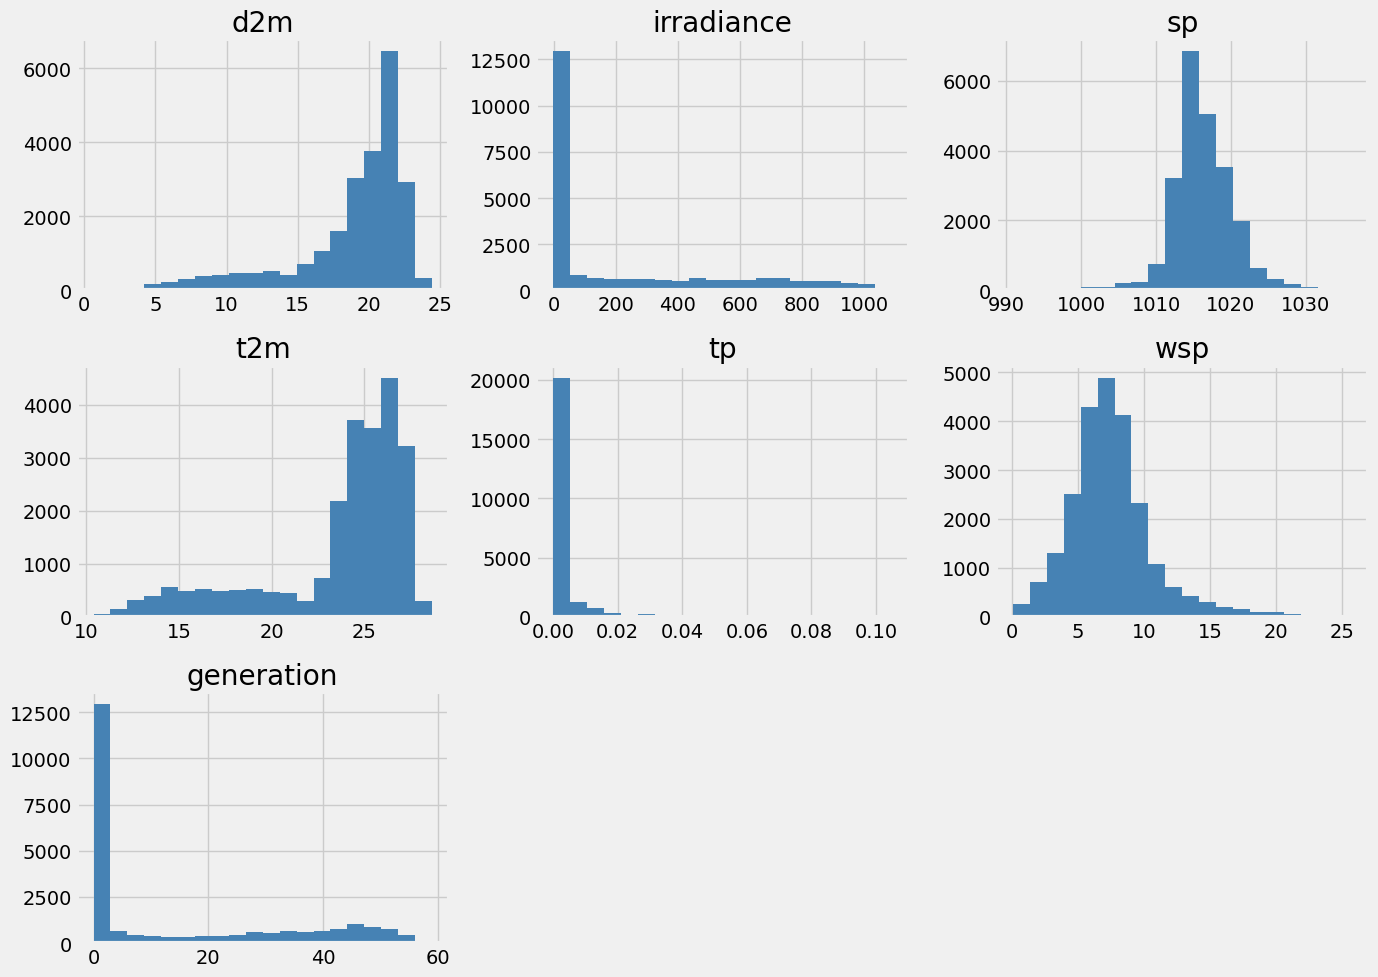

In [3]:
df.hist(bins=20, figsize=(14, 10), color='steelblue')
plt.tight_layout()
plt.savefig('imgs/exploratory_analysis/features_histogram.jpg',bbox_inches='tight')
plt.show()

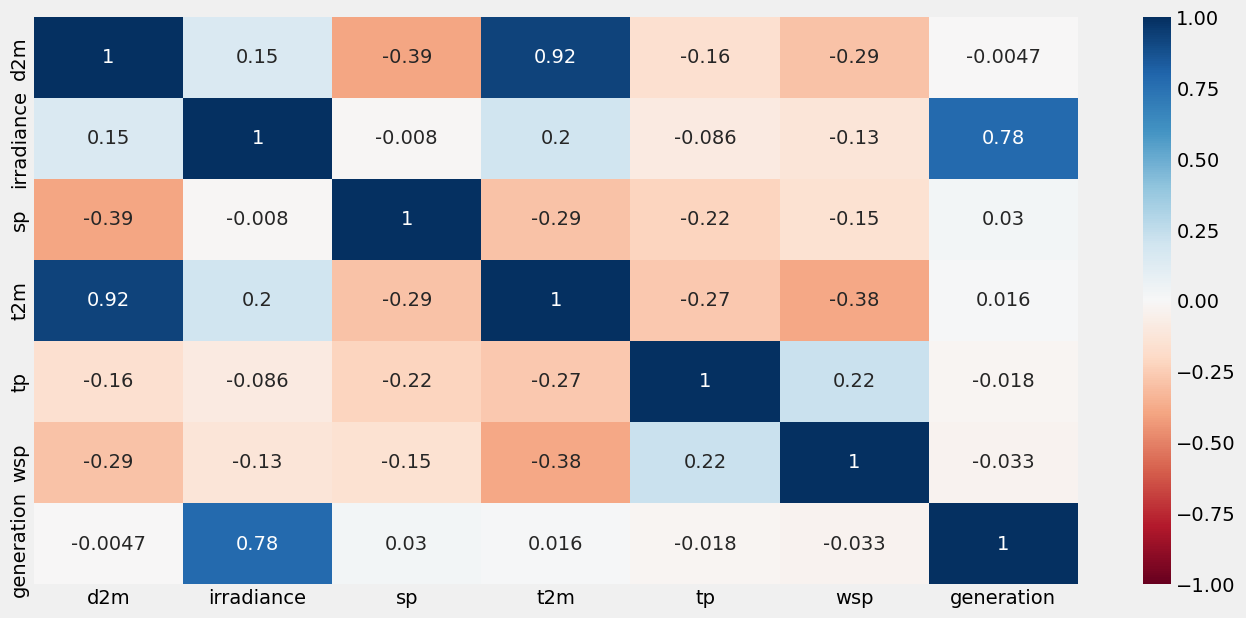

In [4]:
fig, ax = plt.subplots(figsize=(15,7))
matrix = df.corr()
sns.heatmap(matrix, annot=True, vmax=1, vmin=-1, center=0, cmap='RdBu')
plt.savefig('imgs/exploratory_analysis/features_corr_heatmap.jpg',bbox_inches='tight')
plt.show()

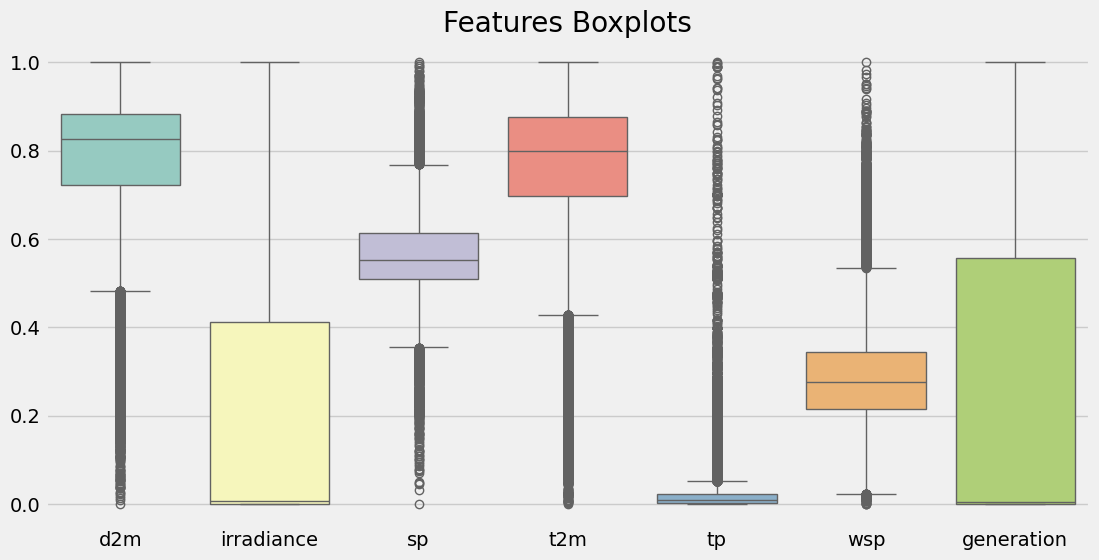

In [5]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_scaled, palette="Set3")
plt.title('Features Boxplots')
plt.savefig('imgs/exploratory_analysis/features_boxplot.jpg',bbox_inches='tight')
plt.show()

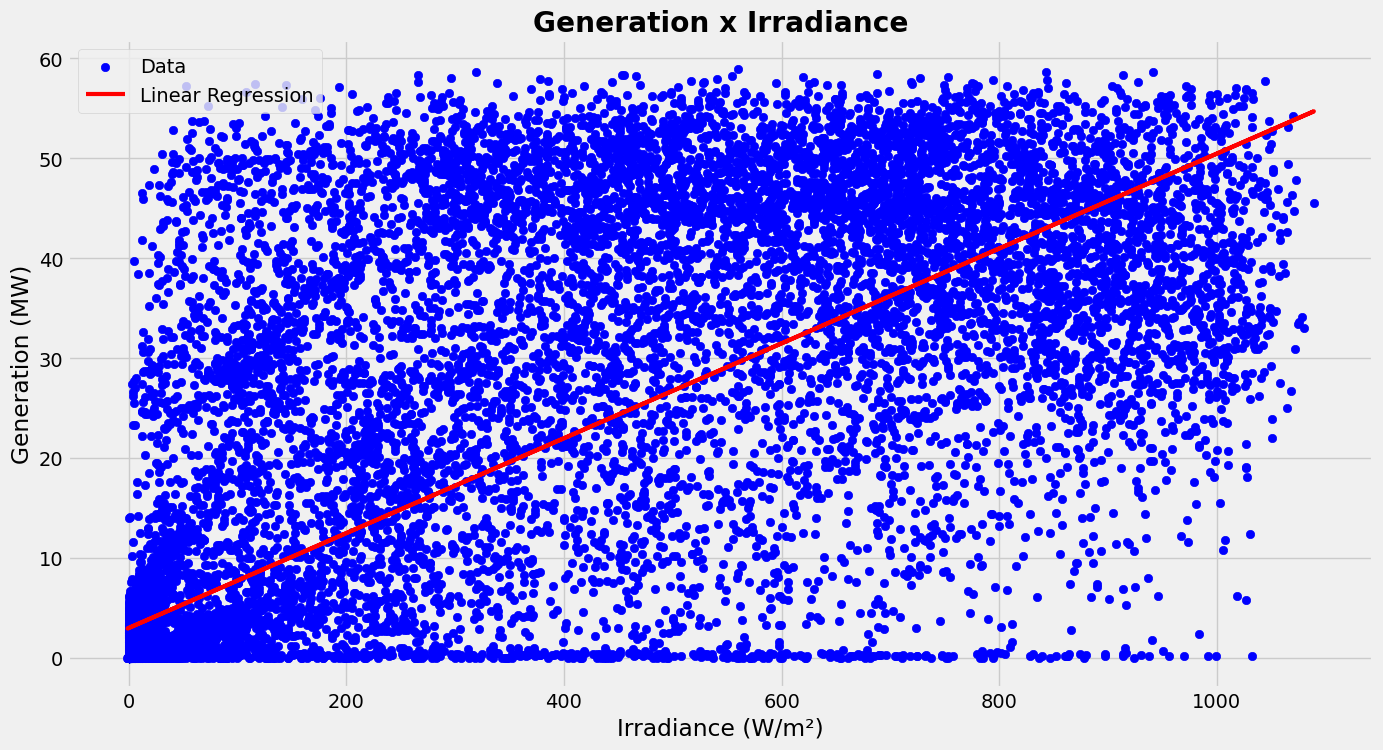

In [6]:
X = df[['irradiance']]
y = df['generation']

end_train = int(len(X)*0.7)
X_train, X_test, y_train, y_test = X.iloc[:end_train], X.iloc[end_train:], y.iloc[:end_train], y.iloc[end_train:]

# Criando modelo de Regressão Linear
lr = LinearRegression()
lr.fit(X_train, y_train)

# Previsões no conjunto de teste
y_pred = lr.predict(X_test)

plt.figure(figsize=(15, 8))
plt.scatter(df['irradiance'].values, df['generation'].values, color='blue', label='Data')
plt.plot(X_test, y_pred, color='red', linewidth=3, label='Linear Regression')
plt.xlabel('Irradiance (W/m²)')
plt.ylabel('Generation (MW)')
plt.title('Generation x Irradiance', weight='bold')
plt.legend()
plt.savefig('imgs/exploratory_analysis/gen_vs_irr_scatter.jpg',bbox_inches='tight')
plt.show()

In [7]:
#decomposition = sm.tsa.seasonal_decompose(df['val_geracao'], model='additive', period=24*30)
#plt.figure(figsize=(15,8))
#decomposition.plot()
#plt.show()

In [8]:
pca = pca(df_scaled, n_components=5, tol=0.15, svd_solver='covariance_eigh')
variance = pd.DataFrame(pca[1]['Variância'])
variance.index = pca[0].columns
variance.columns = ['Explained variance (%)']
variance['Explained variance (%)'] = variance['Explained variance (%)'].apply(lambda x: round(x*100, 2))
variance

,Explained variance (%)
PC1,57.10
PC2,26.74
PC3,6.33
PC4,5.05
PC5,2.53


In [9]:
pca_features = pd.DataFrame(pca[1]['Eixo principal por feature']).T
pca_features.index = df_scaled.columns
pca_features.columns = pca[0].columns
pca_features

,PC1,PC2,PC3,PC4,PC5
d2m,0.059175,0.596310,-0.183999,0.163983,0.046485
irradiance,0.648569,0.063572,0.728690,0.206730,0.026505
sp,-0.001693,-0.111500,0.143840,-0.435884,-0.541844
t2m,0.091327,0.742734,-0.103942,-0.039793,-0.183859
tp,-0.014230,-0.071469,-0.071481,0.241740,0.640116
wsp,-0.033726,-0.175101,-0.164795,0.811762,-0.509636
generation,0.752445,-0.201291,-0.609421,-0.146281,-0.016143


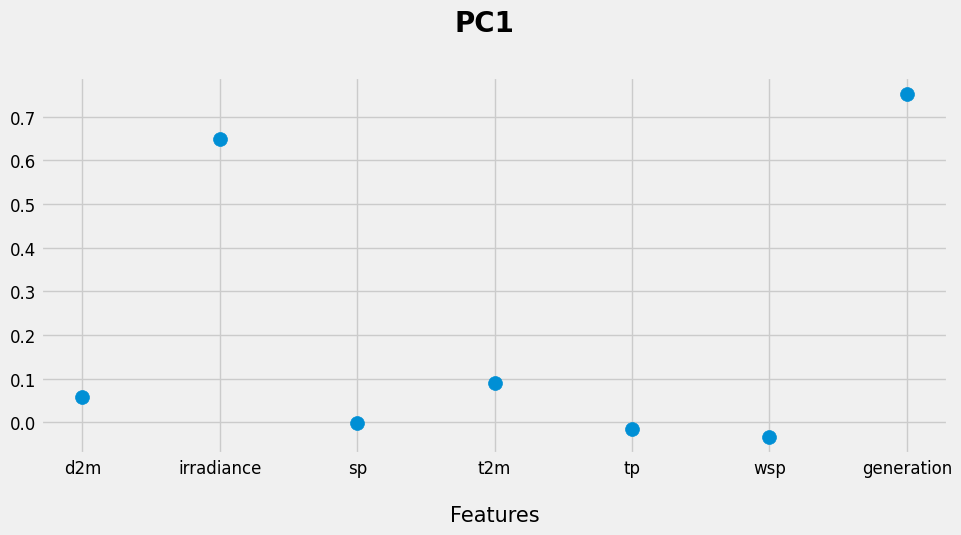

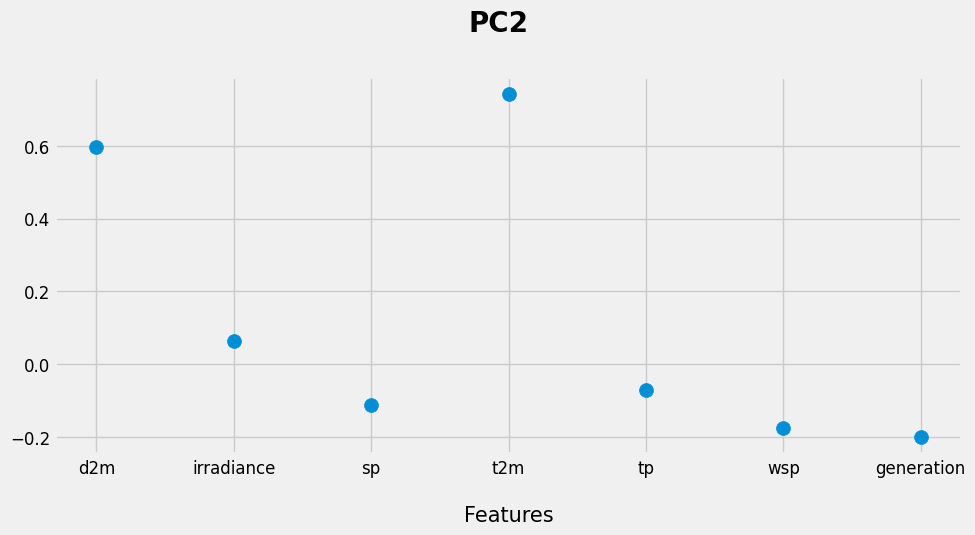

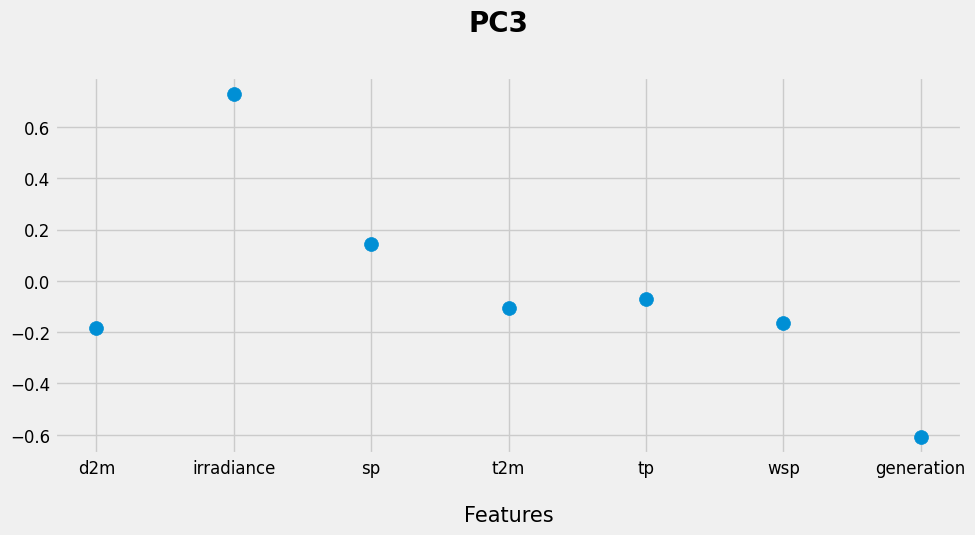

In [10]:
for i in range(1, 4):
    fig, ax = plt.subplots(figsize=(10, 5))

    fig.suptitle(f'PC{i}', weight='bold', fontsize=20)

    fig.tight_layout()

    pc1 = ax.scatter(pca_features.index, 
                     pca_features.loc[:, f'PC{i}'], 
                     s=100)

    ax.set_xlabel('Features', fontsize=15, labelpad=20)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.savefig(f'imgs/exploratory_analysis/PC{i}_per_feature.jpg',bbox_inches='tight')

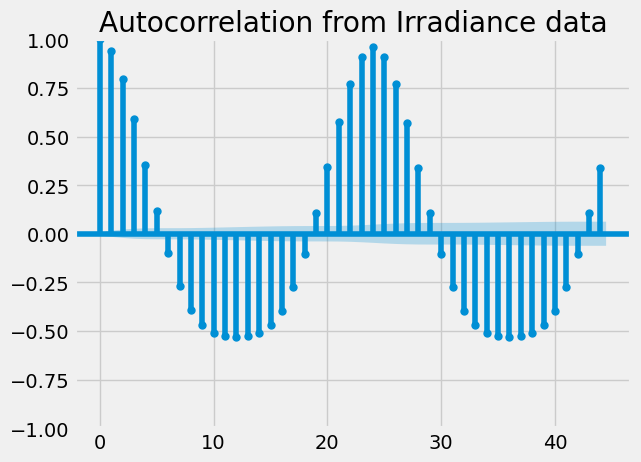

In [15]:
fig, ax = plt.subplots()
plot_acf(df['irradiance'], title='Autocorrelation from Irradiance data', ax=ax)
plt.savefig('imgs/exploratory_analysis/autocorrelation_generation.jpg',bbox_inches='tight')
plt.show()

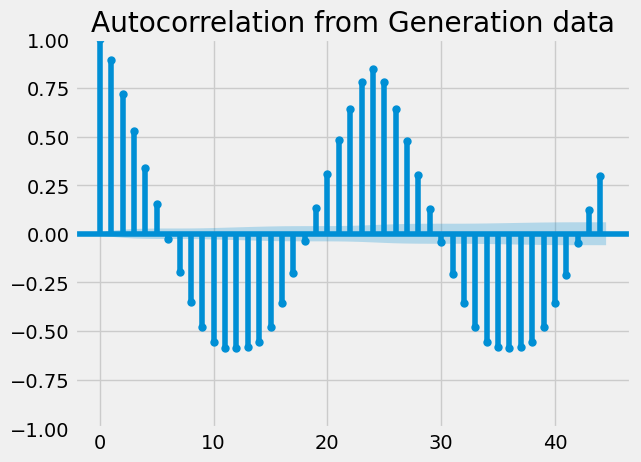

In [12]:
fig, ax = plt.subplots()
plot_acf(df['generation'], title='Autocorrelation from Generation data', ax=ax)
plt.savefig('imgs/exploratory_analysis/autocorrelation_generation.jpg',bbox_inches='tight')
plt.show()

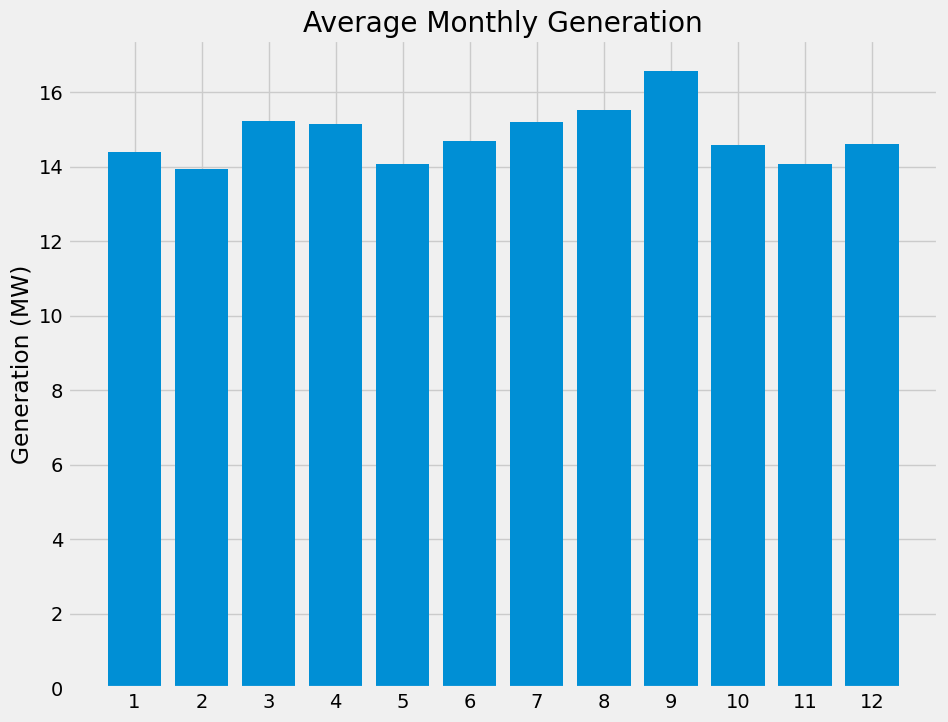

In [13]:
plt.figure(figsize=(10,8))
avg = df.copy()
avg['M'] = df.index.month
avg = avg.groupby('M').mean().loc[:, 'generation']
plt.bar(avg.index, avg.values)
plt.title('Average Monthly Generation')
plt.ylabel('Generation (MW)')
plt.xticks(avg.index)
plt.savefig('imgs/exploratory_analysis/average_monthy_generation.jpg',bbox_inches='tight')
plt.show()

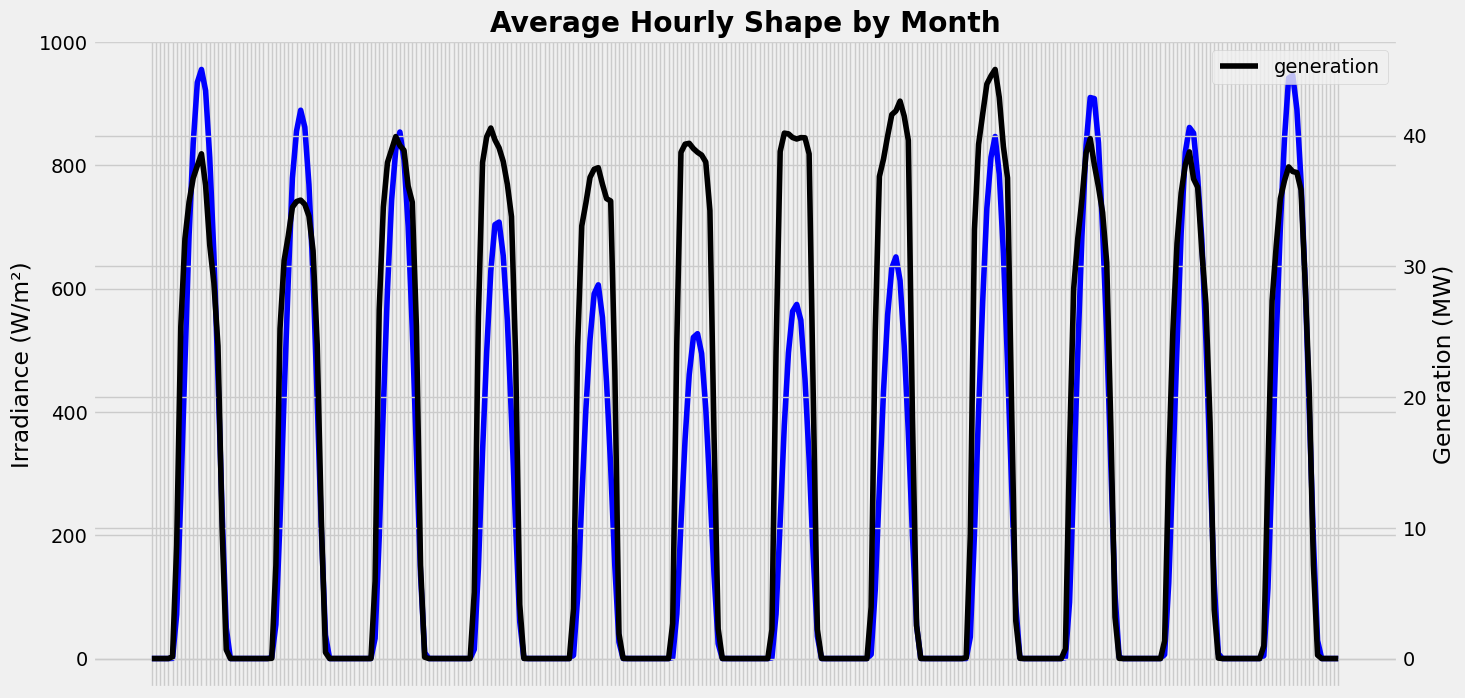

In [14]:
df_m = df[['irradiance', 'generation']].copy()
df_m['MesHora'] = df_m.index.strftime('%m %H:%M')
df_m = df_m.groupby('MesHora').mean()


fig, ax = plt.subplots(figsize=(15,8))
ax.set_xticklabels([])
ax2 = ax.twinx()

ax2.plot(df_m['generation'], color='k', label='generation')
ax2.set_ylabel('Generation (MW)')

ax.plot(df_m['irradiance'], color='b', label='irradiance')
ax.set_ylabel('Irradiance (W/m²)')


plt.legend()
plt.title('Average Hourly Shape by Month', weight='bold')
plt.savefig('imgs/exploratory_analysis/average_hourly_shape_generation_vs_irradiance.jpg',bbox_inches='tight')
plt.show()